In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

# from keras.backend import manual_variable_initialization manual_variable_initialization(True)

In [3]:
# Import required packages
from sklearn.metrics import accuracy_score, classification_report
from random import shuffle
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import dataread
import classifierutils
import logging
import random
import re

import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import sklearn
from nltk.corpus import stopwords
from nltk.tokenize.regexp import regexp_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm

# https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

"""Variables"""

# headers = ['allergies', 'family_history', 'history_illness', 'social_history']
headers = dataread.read_file('custom.txt')
no_sections = 5000

"""Import data"""

# header --> [header, original, tokenized, tokenized_labelled]
header_corpus = {}

for header in headers:
    header_corpus[header] = {}
    header_corpus[header]['label'] = header
    temp = dataread.read_file('section/'+header.replace(' ',
                                                        '_')+str(no_sections)+'.txt')
    new = []
    for sample in temp:
        kek = re.sub("\[.*?\]", "", sample)
        new.append(kek)

    header_corpus[header]['original'] = pd.Series(
        new
    )
    temp = classifierutils.corpus_preprocess(
        header_corpus[header]['original'],
        header
    )
    header_corpus[header]['labelled'] = temp[0]
    header_corpus[header]['labelled_tokenised'] = temp[1]

mixed_labelled = pd.DataFrame()
for value in header_corpus.values():
    mixed_labelled = mixed_labelled.append(value['labelled'])

mixed_labelled_tokenised = pd.DataFrame()
for value in header_corpus.values():
    mixed_labelled_tokenised = mixed_labelled_tokenised.append(
        value['labelled_tokenised'])

mixed_labelled = shuffle(mixed_labelled)

'Variables'

'Import data'

In [4]:
mixed_labelled.head()

,TEXT,HEADER
2220,patient year old male history metastatic melan...,history of present illness
3727,ceftin morphine vicodin,allergies
3571,sulfonamides iodine iodine containing procaina...,allergies
4113,patient recorded known allergies drugs,allergies
1561,patient history coronary artery disease presen...,history of present illness


In [5]:
mixed_labelled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17418 entries, 2220 to 2034
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   TEXT    17418 non-null  object
 1   HEADER  17418 non-null  object
dtypes: object(2)
memory usage: 408.2+ KB


In [6]:
mixed_labelled.HEADER.value_counts()

history of present illness    4707
allergies                     4556
social history                4302
family history                3853
Name: HEADER, dtype: int64

In [7]:
mixed_labelled['HEADER'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Samples', 
                                                                title='Number of samples in each section header')

In [8]:
def print_plot(index):
    example = mixed_labelled[mixed_labelled.index == index][['TEXT', 'HEADER']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [9]:
print_plot(10)

living alone independently prior last hospitalization several children grandchildren area involved care denies alcohol tobacco use
Product: social history


In [10]:
print_plot(3000)

pt immigrated currently lives alone home receives support daughter today drank cognac vodka twice day stopped years ago cigarette substance use
Product: social history


In [11]:
mixed_labelled = mixed_labelled.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
mixed_labelled['TEXT'] = mixed_labelled['TEXT'].apply(clean_text)

In [12]:
mixed_labelled['TEXT'] = mixed_labelled['TEXT'].str.replace('\d+', '')

In [13]:
print_plot(10)

yo non ischemic valvular cardiomyopathy ef echo severe p valvuloplasty paf esrd hd htn hyperlipidemia pvd anemia chronic disease p pea anoic brain injury tranferred management hypotension patient history notable complicated admission ccu briefly admitted wtih chf eacerbation pulmonary edema pt became febrile develeoped new onset murmurs pt presumed endocardititis tee obtained showed severe aortic stenosis valvuloplasty performed unsuccessful second valvuloplasty performed successfully decreased aortic gradient mmhg procedure pt suffered pea arrest coded min subsequent anoic brain injury pt underwent prolonged intubation mo c ed rehab plans f u aortic valve surgery felt good surgical candidate pt well rehab hd lasi fluid removal pta went leave rehab large salty meal return rehab episode acute sob lh cp taken hosp found mildly decompensated heart failure bp cardiac w u dialysis removed another kg fluid total pressure dropped pt started pressors came mgmt hypotension pressors map mcg kg m

In [14]:
print_plot(100)

ms year old female cad htn hypercholesteremia presents shortness breath patient short term memory loss difficult historian family present majority hpi obtained omr ed notes patient sob developed accompanied tachypnea increased work breathing per family patient noncompliant meds also productive cough white green sputum multiple days fevers ems called transit patient found hypertensive tachy tachypneic nrb recieved iv lasi sl nitro nebs slight improvement upon arrival ed vitals ra nitro gtt started hypertensive urgency pt treated asa hydralazine prn albuterol ipratroprium nebs solumedrol iv improvement respiratory status however nitro stopped sbp cc ns given also placed bipap respiratory distress tachypnic also stopped hypotension blood pressure recovered became hypertensive sbp time nitro restarted stopped ed decided resume bipap instead patient looked uncomfortable cr done without evidence infiltrate chf although pro bnp elevated ekg sinus tachycardia faed dr read lvf strain cardiac en

In [15]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(mixed_labelled['TEXT'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 17381 unique tokens.


In [16]:
X = tokenizer.texts_to_sequences(mixed_labelled['TEXT'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (17418, 250)


In [17]:
Y = pd.get_dummies(mixed_labelled['HEADER']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (17418, 4)


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(15676, 250) (15676, 4)
(1742, 250) (1742, 4)


In [19]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 4)                 404       
Total params: 5,080,804
Trainable params: 5,080,804
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
epochs = 2
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/2
221/221 [==============================] - 322s 1s/step - loss: 0.4048 - accuracy: 0.8652 - f1_m: 0.7911 - precision_m: 0.8851 - recall_m: 0.7444 - val_loss: 0.1515 - val_accuracy: 0.9617 - val_f1_m: 0.9596 - val_precision_m: 0.9881 - val_recall_m: 0.9331
Epoch 2/2
221/221 [==============================] - 312s 1s/step - loss: 0.1077 - accuracy: 0.9643 - f1_m: 0.9666 - precision_m: 0.9875 - recall_m: 0.9470 - val_loss: 0.1257 - val_accuracy: 0.9630 - val_f1_m: 0.9633 - val_precision_m: 0.9888 - val_recall_m: 0.9394


In [21]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

55/55 [==============================] - 5s 94ms/step - loss: 0.1066 - accuracy: 0.9604 - f1_m: 0.9634 - precision_m: 0.9911 - recall_m: 0.9379
Test set
  Loss: 0.107
  Accuracy: 0.960


In [22]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(Y_test)
# print(classification_report(Y_test, y_pred_bool))

28/28 [==============================] - 4s 147ms/step
[[0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 ...
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]]


In [23]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)
print(accuracy)
print(f1_score)
print(precision)
print(recall)
print(loss)




0.9603903293609619
0.9634310603141785
0.9910798668861389
0.9379057884216309
0.10664691776037216


In [24]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

y_test = np.argmax(Y_test, axis=1)

print(classification_report(y_test, y_pred_bool, target_names=sorted(headers)))

28/28 [==============================] - 4s 130ms/step
                            precision    recall  f1-score   support

                 allergies       0.98      0.98      0.98       433
            family history       0.98      0.91      0.94       383
history of present illness       1.00      0.97      0.98       490
            social history       0.89      0.98      0.93       436

                  accuracy                           0.96      1742
                 macro avg       0.96      0.96      0.96      1742
              weighted avg       0.96      0.96      0.96      1742



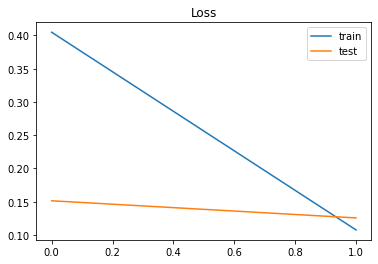

In [33]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

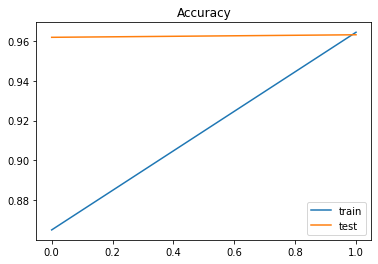

In [26]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [27]:
new_complaint = ["""No Known Drug Allergies"""]
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = sorted(headers)
print(labels)
print(pred, labels[np.argmax(pred)])

['allergies', 'family history', 'history of present illness', 'social history']
[[9.9995279e-01 7.6630322e-06 1.5271302e-05 2.4323845e-05]] allergies


In [28]:
# model.save('model/LTSM_RNN_2EP_91.h5')
# model.save_weights('model/LTSM_RNN_2EP_91_w.h5')

for labels in sorted(headers):
    print("\item ", labels)

\item  allergies
\item  family history
\item  history of present illness
\item  social history


In [29]:
import dataclass
import importlib
dataclass = importlib.reload(dataclass)
samples = pd.DataFrame()
for value in header_corpus.values():
    samples = samples.append(value['labelled'])

data = dataread.read_samples(2)
data_class = []
for item in data:
    data_class.append(
        dataclass.Sample(item)
    )

labels = sorted(headers)

for item in data_class:
    item.paragraph_classify(model, tokenizer, labels)

export = []
for item in data_class:
    item.paragraph_classify_indexed()
    export.append(item.paragraph_classifed_print())

dataread.save_array(export, 'test2.txt')
    

# labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

# corpus = []
# for()


0.9999999776482582 4
1.0000000447034836 4
0.9999999944120646 4
0.9999999962747097 4
1.000000074505806 4
0.9999999292194843 4
1.0000000149011612 4
0.9999999552965164 4
0.9999999776482582 4
0.9999999552965164 4
0.9999999478459358 4
1.0000000704312697 4
1.000000054948032 4
0.9999999990686774 4
1.0000000416766852 4
1.0000000288709998 4
0.9999998976782081 4
0.9999999863539415 4
1.0000000227701094 4
0.999999976833351 4
0.9999999552965164 4
0.9999999580904841 4
0.9999999552965164 4
1.0000000523868948 4
1.0000000051222742 4
1.0 4
0.9999999823048711 4
0.9999999385327101 4
0.9999999450519681 4
1.0000000558793545 4
0.999999962747097 4
0.9999999850988388 4
0.999999969266355 4
1.0000000197906047 4
0.9999999701976776 4
1.0000001043081284 4
1.000000036554411 4
1.0000000223517418 4
0.9999999697320163 4
0.999999962747097 4
0.9999999846331775 4
1.0000000004656613 4
0.9999999813735485 4
1.000000026077032 4
1.0 4
1.0000000272411853 4
0.9999999646097422 4
0.9999999701976776 4
0.9999999850988388 4
0.9999999

In [30]:
# from keras.models import load_model

# model = load_model('model/LTSM_RNN.h5')

In [31]:
# Saved Model

import os
import tempfile

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

tf.saved_model.save(model, 'model/alpha/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/alpha/assets
